In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt

In [3]:
df = pd.read_csv('HUPA0002P.csv', delimiter=';')

In [4]:
df['time'] = pd.to_datetime(df['time'])
df.set_index('time', inplace=True)

In [5]:
print("Dataset shape:", df.shape)
print("\nColumns:", df.columns.tolist())
print("\nFirst few rows:")
print(df.head())
print("\nData types:")
print(df.dtypes)
print("\nMissing values:")
print(df.isnull().sum())

Dataset shape: (3181, 7)

Columns: ['glucose', 'calories', 'heart_rate', 'steps', 'basal_rate', 'bolus_volume_delivered', 'carb_input']

First few rows:
                       glucose  calories  heart_rate  steps  basal_rate  \
time                                                                      
2018-06-13 22:45:00  86.000000   6.21384   65.390244    0.0    0.108333   
2018-06-13 22:50:00  82.000000   6.33568   64.269231    0.0    0.108333   
2018-06-13 22:55:00  78.000000   6.57936   68.162791    0.0    0.108333   
2018-06-13 23:00:00  74.000000   6.09200   63.638655    0.0    0.075000   
2018-06-13 23:05:00  76.666667   6.09200   65.486957    0.0    0.075000   

                     bolus_volume_delivered  carb_input  
time                                                     
2018-06-13 22:45:00                     0.0         0.0  
2018-06-13 22:50:00                     0.0         0.0  
2018-06-13 22:55:00                     8.0         0.0  
2018-06-13 23:00:00            

In [6]:
feature_columns = ['glucose', 'calories', 'heart_rate', 'steps', 'basal_rate', 'carb_input']
target_column = 'bolus_volume_delivered'

In [7]:
print(f"\nTarget variable '{target_column}' statistics:")
print(df[target_column].describe())
print(f"\nUnique values in target: {df[target_column].unique()}")


Target variable 'bolus_volume_delivered' statistics:
count    3181.000000
mean        0.073153
std         0.665905
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max        10.000000
Name: bolus_volume_delivered, dtype: float64

Unique values in target: [ 0.   8.   0.6  7.2  2.5  5.8  5.3  4.   9.9  1.2  3.8  3.5  7.3  2.
  7.7  3.4  6.9  4.2  5.2  4.7  3.   7.4  8.5  0.5  0.9  1.5 10.   6.
  9.6  5.   2.6  4.5  1.9  9.7  8.2  7.5]


In [8]:
def create_sequences(data, features, target, sequence_length=24):
    X, y = [], []
    for i in range(len(data) - sequence_length):
        X.append(data[features].iloc[i:(i + sequence_length)].values)
        y.append(data[target].iloc[i + sequence_length])
    return np.array(X), np.array(y)

In [9]:
sequence_length = 12

In [10]:
scaler = StandardScaler()
scaled_features = scaler.fit_transform(df[feature_columns])
scaled_df = pd.DataFrame(scaled_features, columns=feature_columns, index=df.index)
scaled_df[target_column] = df[target_column].values

In [11]:
X, y = create_sequences(scaled_df, feature_columns, target_column, sequence_length)

In [12]:
print(f"\nSequences created: {X.shape}")
print(f"Target shape: {y.shape}")


Sequences created: (3169, 12, 6)
Target shape: (3169,)


In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)

In [14]:
print(f"\nTraining set: {X_train.shape}, {y_train.shape}")
print(f"Test set: {X_test.shape}, {y_test.shape}")


Training set: (2535, 12, 6), (2535,)
Test set: (634, 12, 6), (634,)


In [15]:
model = Sequential([
    LSTM(64, return_sequences=True, input_shape=(sequence_length, len(feature_columns))),
    Dropout(0.2),
    LSTM(32, return_sequences=True),
    Dropout(0.2),
    LSTM(16),
    Dropout(0.2),
    Dense(8, activation='relu'),
    Dense(1)  # Output layer for regression
])

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [16]:
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='mse',
    metrics=['mae']
)

In [17]:
print("\nModel architecture:")
model.summary()


Model architecture:


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 12, 64)         │        18,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 12, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 12, 32)         │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 12, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 16)             │         3,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 33,873 (132.32 KB)

 Trainable params: 33,873 (132.32 KB)

 Non-trainable params: 0 (0.00 B)

In [18]:
history = model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=32,
    validation_data=(X_test, y_test),
    verbose=1,
    shuffle=False
)

Epoch 1/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 10s 43ms/step - loss: 0.3736 - mae: 0.1283 - val_loss: 0.4505 - val_mae: 0.1304
Epoch 2/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - loss: 0.3683 - mae: 0.1303 - val_loss: 0.4496 - val_mae: 0.1361
Epoch 3/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - loss: 0.3680 - mae: 0.1282 - val_loss: 0.4491 - val_mae: 0.1321
Epoch 4/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 0.3675 - mae: 0.1350 - val_loss: 0.4501 - val_mae: 0.1413
Epoch 5/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - loss: 0.3657 - mae: 0.1369 - val_loss: 0.4506 - val_mae: 0.1357
Epoch 6/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 0.3657 - mae: 0.1371 - val_loss: 0.4495 - val_mae: 0.1335
Epoch 7/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 0.3615 - mae: 0.1299 - val_loss: 0.4523 - val_mae: 0.1463
Epoch 8/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 0.3652 - mae: 0.1381 - val_loss: 0.4487 - val_mae: 0.1405
Epoch 9/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 0.36

In [19]:
train_loss, train_mae = model.evaluate(X_train, y_train, verbose=0)
test_loss, test_mae = model.evaluate(X_test, y_test, verbose=0)

In [20]:
print(f"\nTraining MAE: {train_mae:.4f}")
print(f"Test MAE: {test_mae:.4f}")


Training MAE: 0.1203
Test MAE: 0.1640


In [21]:
y_pred = model.predict(X_test)

20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step


In [22]:
plt.figure(figsize=(12, 4))

<Figure size 1200x400 with 0 Axes>

<Figure size 1200x400 with 0 Axes>

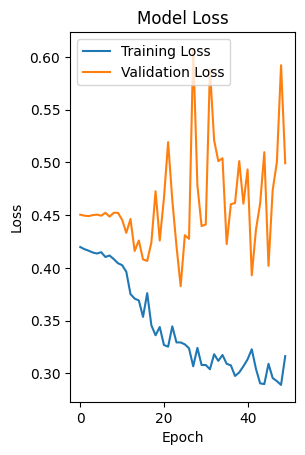

In [23]:
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

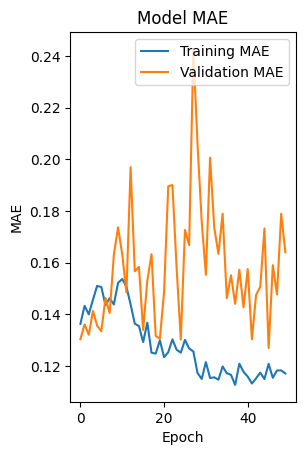

In [24]:
plt.subplot(1, 2, 2)
plt.plot(history.history['mae'], label='Training MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.title('Model MAE')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()

In [25]:
plt.tight_layout()
plt.show()

<Figure size 640x480 with 0 Axes>

In [26]:
plt.figure(figsize=(12, 6))

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

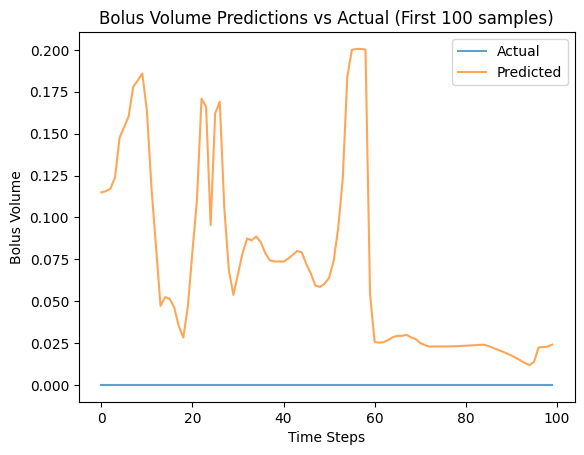

In [27]:
plt.plot(y_test[:100], label='Actual', alpha=0.7)
plt.plot(y_pred[:100], label='Predicted', alpha=0.7)
plt.title('Bolus Volume Predictions vs Actual (First 100 samples)')
plt.xlabel('Time Steps')
plt.ylabel('Bolus Volume')
plt.legend()
plt.show()

In [28]:
def calculate_feature_importance(model, X_test, y_test, feature_names):
    baseline_loss = model.evaluate(X_test, y_test, verbose=0)[0]
    importance_scores = []

    for i in range(len(feature_names)):
        X_permuted = X_test.copy()
        # Shuffle the feature
        X_permuted[:, :, i] = np.random.permutation(X_permuted[:, :, i])
        permuted_loss = model.evaluate(X_permuted, y_test, verbose=0)[0]
        importance = permuted_loss - baseline_loss
        importance_scores.append(importance)

    return importance_scores

feature_importance = calculate_feature_importance(model, X_test, y_test, feature_columns)

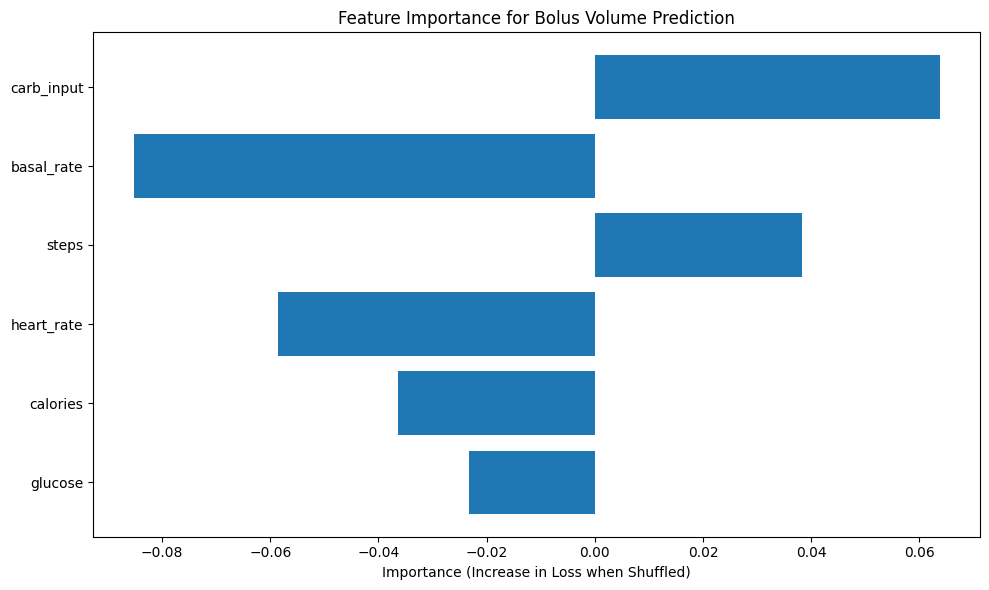

In [29]:
plt.figure(figsize=(10, 6))
plt.barh(feature_columns, feature_importance)
plt.title('Feature Importance for Bolus Volume Prediction')
plt.xlabel('Importance (Increase in Loss when Shuffled)')
plt.tight_layout()
plt.show()

In [30]:
print("\nFeature Importance Scores:")
for feature, importance in zip(feature_columns, feature_importance):
    print(f"{feature}: {importance:.6f}")


Feature Importance Scores:
glucose: -0.023239
calories: -0.036459
heart_rate: -0.058654
steps: 0.038366
basal_rate: -0.085254
carb_input: 0.063749


In [31]:
model.save('bolus_volume_lstm_model.h5')
print("\nModel saved as 'bolus_volume_lstm_model.h5'")


Model saved as 'bolus_volume_lstm_model.h5'
